# Feature Selection 

In [23]:
import random
import gc 
import datetime as dt
import numpy as np 
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [18]:
train = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
prop = pd.read_csv("../input/properties_2016.csv")
submission = pd.read_csv("../submissions/sample_submission.csv")
print(len(train),len(prop),len(submission))

/home/bss/opt/anaconda3/envs/zillow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


90275 2985217 2985217


In [19]:
# feature engineering
prop['prop_age'] = 2018 - prop['yearbuilt']  # property age
prop['total_rm_ct'] = prop['bathroomcnt'] + prop['bedroomcnt']  # total bed rm+ bathrm
prop["location"] = prop["latitude"] + prop["longitude"]  # location total

def get_features(df):
    df["transactiondate"] = pd.to_datetime(df["transactiondate"])
    df["transactiondate_year"] = df["transactiondate"].dt.year
    df["transactiondate_month"] = df["transactiondate"].dt.month
    df['transactiondate'] = df['transactiondate'].dt.quarter
    df = df.fillna(-1.0)
    return df

def MAE(y, ypred):
    #logerror=log(Zestimate)−log(SalePrice)
    return np.sum([abs(y[i]-ypred[i]) for i in range(len(y))]) / len(y)

train = pd.merge(train, prop, how='left', on='parcelid')
y = train['logerror'].values
test = pd.merge(submission, prop, how='left', left_on='ParcelId', right_on='parcelid')
properties = [] #memory

exc = [train.columns[c] for c in range(len(train.columns)) if train.dtypes[c] == 'O'] + ['logerror','parcelid']
col = [c for c in train.columns if c not in exc]

train = get_features(train[col])
test['transactiondate'] = '2016-01-01' #should use the most common training date
test = get_features(test[col])

'''reg = LinearRegression(n_jobs=-1)
reg.fit(train, y); print('fit...')
print(MAE(y, reg.predict(train)))
train = [];  y = [] #memory

test_dates = ['2016-10-01','2016-11-01','2016-12-01','2017-10-01','2017-11-01','2017-12-01']
test_columns = ['201610','201611','201612','201710','201711','201712']'''

/home/bss/opt/anaconda3/envs/zillow/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/bss/opt/anaconda3/envs/zillow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/bss/opt/anaconda3/envs/zillow/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

"reg = LinearRegression(n_jobs=-1)\nreg.fit(train, y); print('fit...')\nprint(MAE(y, reg.predict(train)))\ntrain = [];  y = [] #memory\n\ntest_dates = ['2016-10-01','2016-11-01','2016-12-01','2017-10-01','2017-11-01','2017-12-01']\ntest_columns = ['201610','201611','201612','201710','201711','201712']"

## Model-Based Selection

Consider all features at once

In [20]:
'''
median for half features to be selected
'''
select = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold="median")

In [21]:
select.fit(train, y)
x_train_l1 = select.transform(train)
print('x_train shape: ', train.shape)
print('x_train_l1 shape: ', x_train_l1)

x_train shape:  (90275, 58)
x_train_l1 shape:  [[  1.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   5.00000000e+00
   -8.42075460e+07   1.00000000e+00]
 [  1.00000000e+00  -1.00000000e+00   3.50000000e+00 ...,   7.50000000e+00
   -8.40094360e+07   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   3.00000000e+00 ...,   5.00000000e+00
   -8.40387200e+07   1.00000000e+00]
 ..., 
 [  4.00000000e+00  -1.00000000e+00   2.00000000e+00 ...,   6.00000000e+00
   -8.39498820e+07   1.20000000e+01]
 [  4.00000000e+00  -1.00000000e+00   2.00000000e+00 ...,   4.00000000e+00
   -8.44031000e+07   1.20000000e+01]
 [  4.00000000e+00  -1.00000000e+00   1.00000000e+00 ...,   4.00000000e+00
   -8.43801600e+07   1.20000000e+01]]


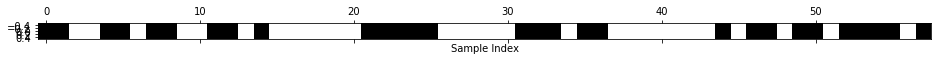

In [26]:
mask = select.get_support()
# visualize 
# black = TRUE
# white = FALSE
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample Index')

In [ ]:
X_test_l1 = select.transform(x_t)